In [1085]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import cv2
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [1086]:
table = pd.read_csv('./train_data.txt', header=None)

In [1087]:
table.shape

(10740, 784)

In [1088]:
table_scaled= table/255.0

In [1089]:
scaled_data = table_scaled.values.reshape([-1,28,28,1])

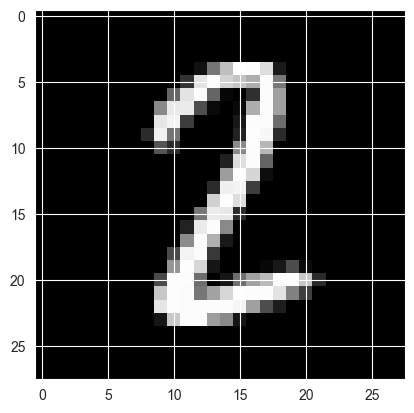

In [1090]:
plt.imshow(scaled_data[60],cmap='gray')

In [1048]:
def averaging(img):
    return cv2.blur(img,(2,2))

In [1092]:
def gaussian(img):
    return cv2.GaussianBlur(img,(3,3),0)

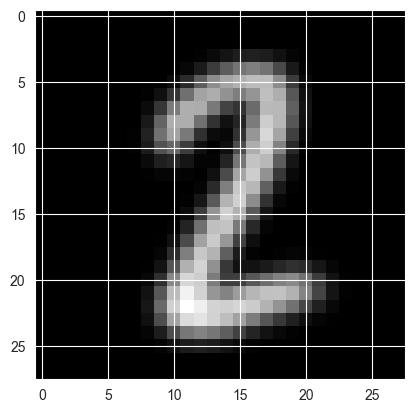

In [1093]:
plt.imshow(averaging(gaussian(scaled_data[60])), cmap='gray')

In [1094]:
image_transformed = []
for i in range(scaled_data.shape[0]):
    image_transformed.append(averaging(gaussian(scaled_data[i])).reshape(-1,784))
transformed_np_array = np.array(image_transformed)

In [1095]:
data = transformed_np_array.reshape(transformed_np_array.shape[0],transformed_np_array.shape[-1])

In [1096]:
data.shape

(10740, 784)

In [1098]:
pca = PCA(n_components=.99)
data = pca.fit_transform(data)

In [1099]:
data.shape

(10740, 86)

In [1100]:
tsne = TSNE(n_components=2,
            n_iter=5000,
            n_iter_without_progress=250,
            perplexity=19,
            early_exaggeration=26)
data_to_lower_dim = tsne.fit_transform(data)

/Users/bhabaranjanpanigrahi/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/bhabaranjanpanigrahi/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [1101]:
scaler = MinMaxScaler(feature_range=(1,100))
data_scaled_and_transformed = scaler.fit_transform(data_to_lower_dim)

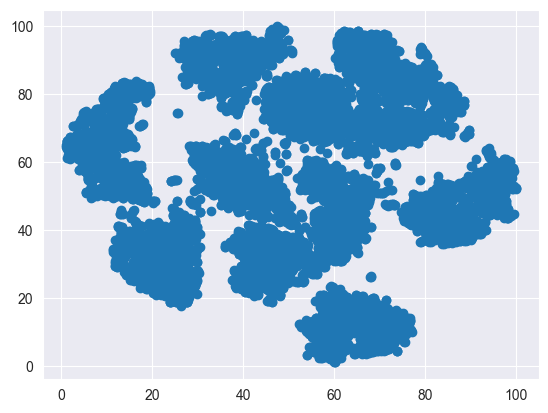

In [1102]:
plt.scatter(data_scaled_and_transformed[:,0], data_scaled_and_transformed[:,1])

In [1103]:
def generateKCentroid(data, k):
    random_index = [ np.random.randint(0,data.shape[0],size=data.shape[1]) for i in range(k)]
    centroids = []
    for i in range(len(random_index)):
        curr = random_index[i]
        build_centroid = []
        for j in range(len(curr)):
            build_centroid.append(data[curr[j],j])
        centroids.append(build_centroid)
    return np.array(centroids)

In [1104]:
def calculateInertia(data_set, centroid, cluster_assigned):
    sum_of_squared_distance = 0
    cluster_assigned = np.array(cluster_assigned)
    centroid = np.array(centroid)
    for i in range(cluster_assigned.shape[0]):
        distance = euclidean_distances(data_set[i].reshape(1,-1), centroid[cluster_assigned[i]].reshape(1,-1))
        sum_of_squared_distance += (distance*distance)
    return sum_of_squared_distance

In [1113]:
from sklearn.metrics.pairwise import euclidean_distances
def runKmeanClustering(cluster_size, train_data, centroids):
    iteration = 0
    while True:
        iteration += 1
        restart = False
        distance_e = euclidean_distances(train_data, centroids)
        distance = distance_e

        cluster_assigned  = np.argmin(distance, axis=1)
        cluster_bucket = {}

        for i in range(cluster_size):
            cluster_bucket[i] = []

        for index in range(cluster_assigned.shape[0]):
            cluster_bucket[cluster_assigned[index]].append(train_data[index])

        for cluster in range(cluster_size):
            if len(cluster_bucket[cluster]) == 0:
                print("cluster with ID=====> "+ str(cluster) + " does not have any data points" )
                print("re-initializing centroids")
                centroids = generateKCentroid(data, cluster_size)
                restart = True
                break

        if restart:
            print("re-staring k-means")
            continue
        centroid_of_cluster = []

        for cluster in range(cluster_size):
            centroid_of_cluster.append(np.mean(np.array(cluster_bucket[cluster]) ,axis=0))

        if np.array_equal(centroid_of_cluster, centroids):
            return centroids, cluster_assigned
        else:
            centroids = np.array(centroid_of_cluster)

In [1114]:
def runKmeansWithParams(train_data, num_cluster, init_cluster_size, step_increament = 1, num_iteration = 10):
    choosen_best_cluster_and_inertia = []
    cluster_to_process = []
    init_cluster = init_cluster_size

    for cluster in range(num_cluster):
        cluster_to_process.append(init_cluster + step_increament)
        init_cluster += step_increament

    for k in cluster_to_process:
        save_cluster =[]
        save_intertia = []
        print("cluster_size:>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>", k)
        for i in range(num_iteration):
            print("iteration:================================================>", i)
            k_centroids, assigned_cluster = runKmeanClustering(k, train_data, generateKCentroid(train_data,k))
            save_cluster.append(assigned_cluster)
            save_intertia.append(calculateInertia(train_data,k_centroids,assigned_cluster))

        index = np.argmin(save_intertia)
        choosen_best_cluster_and_inertia.append((save_cluster[index], save_intertia[index]))

    return choosen_best_cluster_and_inertia

In [1115]:
data = data_scaled_and_transformed

In [1116]:
r = runKmeansWithParams(data,1,10,0,200)

cluster_size:>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 10
iteration:================================================> 0
iteration:================================================> 1
iteration:================================================> 2
iteration:================================================> 3
cluster with ID=====> 7 does not have any data points
re-initializing centroids
re-staring k-means
cluster with ID=====> 4 does not have any data points
re-initializing centroids
re-staring k-means
iteration:================================================> 4
iteration:================================================> 5
iteration:================================================> 6
iteration:================================================> 7
cluster with ID=====> 6 does not have any data points
re-initializing centroids
re-staring k-means
iteration:================================================> 8
iteration:================================================> 9
iteration:======

In [1069]:

save_cluster =[]
save_intertia = []
for i in range(200):
    print("iteration:================================================>",i)
    k_centroids, assigned_cluster = runKmeanClustering(10, data, generateKCentroid(data,10, data.shape[1]))
    save_cluster.append(assigned_cluster)
    save_intertia.append(calculateInertia(data,k_centroids,assigned_cluster))

index = np.argmin(save_intertia)

iteration:================================================> 0
iteration:================================================> 1
iteration:================================================> 2
iteration:================================================> 3
iteration:================================================> 4
cluster does not have any data points:  9
restart
iteration:================================================> 5
cluster does not have any data points:  6
restart
cluster does not have any data points:  5
restart
iteration:================================================> 6
iteration:================================================> 7
iteration:================================================> 8
iteration:================================================> 9
iteration:================================================> 10
iteration:================================================> 11
iteration:================================================> 12
iteration:===============================

In [1120]:
r[0][0]

array([1, 7, 7, ..., 5, 6, 1])

In [1121]:
assigned_cluster = r[0][0]
print(index)

0


In [1122]:
print(assigned_cluster)

[1 7 7 ... 5 6 1]


In [1123]:
assigned_cluster += 1
print(assigned_cluster)

[2 8 8 ... 6 7 2]


In [1124]:
from sklearn.metrics import silhouette_score
silhouette_score(data, assigned_cluster)
# z = []
# for i in range(200):
#     z.append(silhouette_score(data, save_cluster[i]))

0.48754328

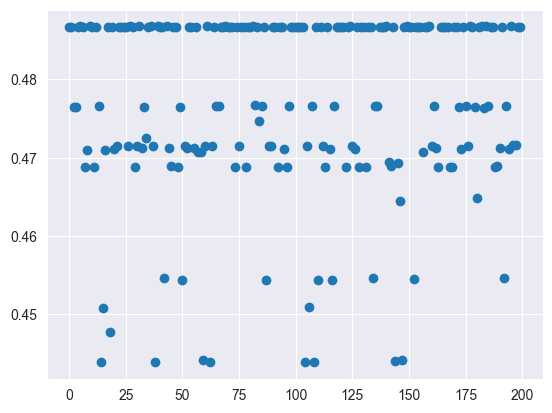

In [1079]:
plt.scatter(range(200), z)

In [1126]:
import csv
outfile = open('./results.csv','w')
out = csv.writer(outfile)
out.writerows(map(lambda x: [x], assigned_cluster))
outfile.close()

In [8]:
x = []
for i in range(397):
    unique, counts =  np.unique(data_repeated[:,i], return_counts=True)
    mask = np.zeros(392)
    s = 0
    for number, count in zip(unique, counts):
        s += count
        mask[number] = count
    # print(s,i)
    x.append(mask)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [204]:
import seaborn as sns
import matplotlib.pyplot as plt

In [205]:
x = np.array(x)

<AxesSubplot: >

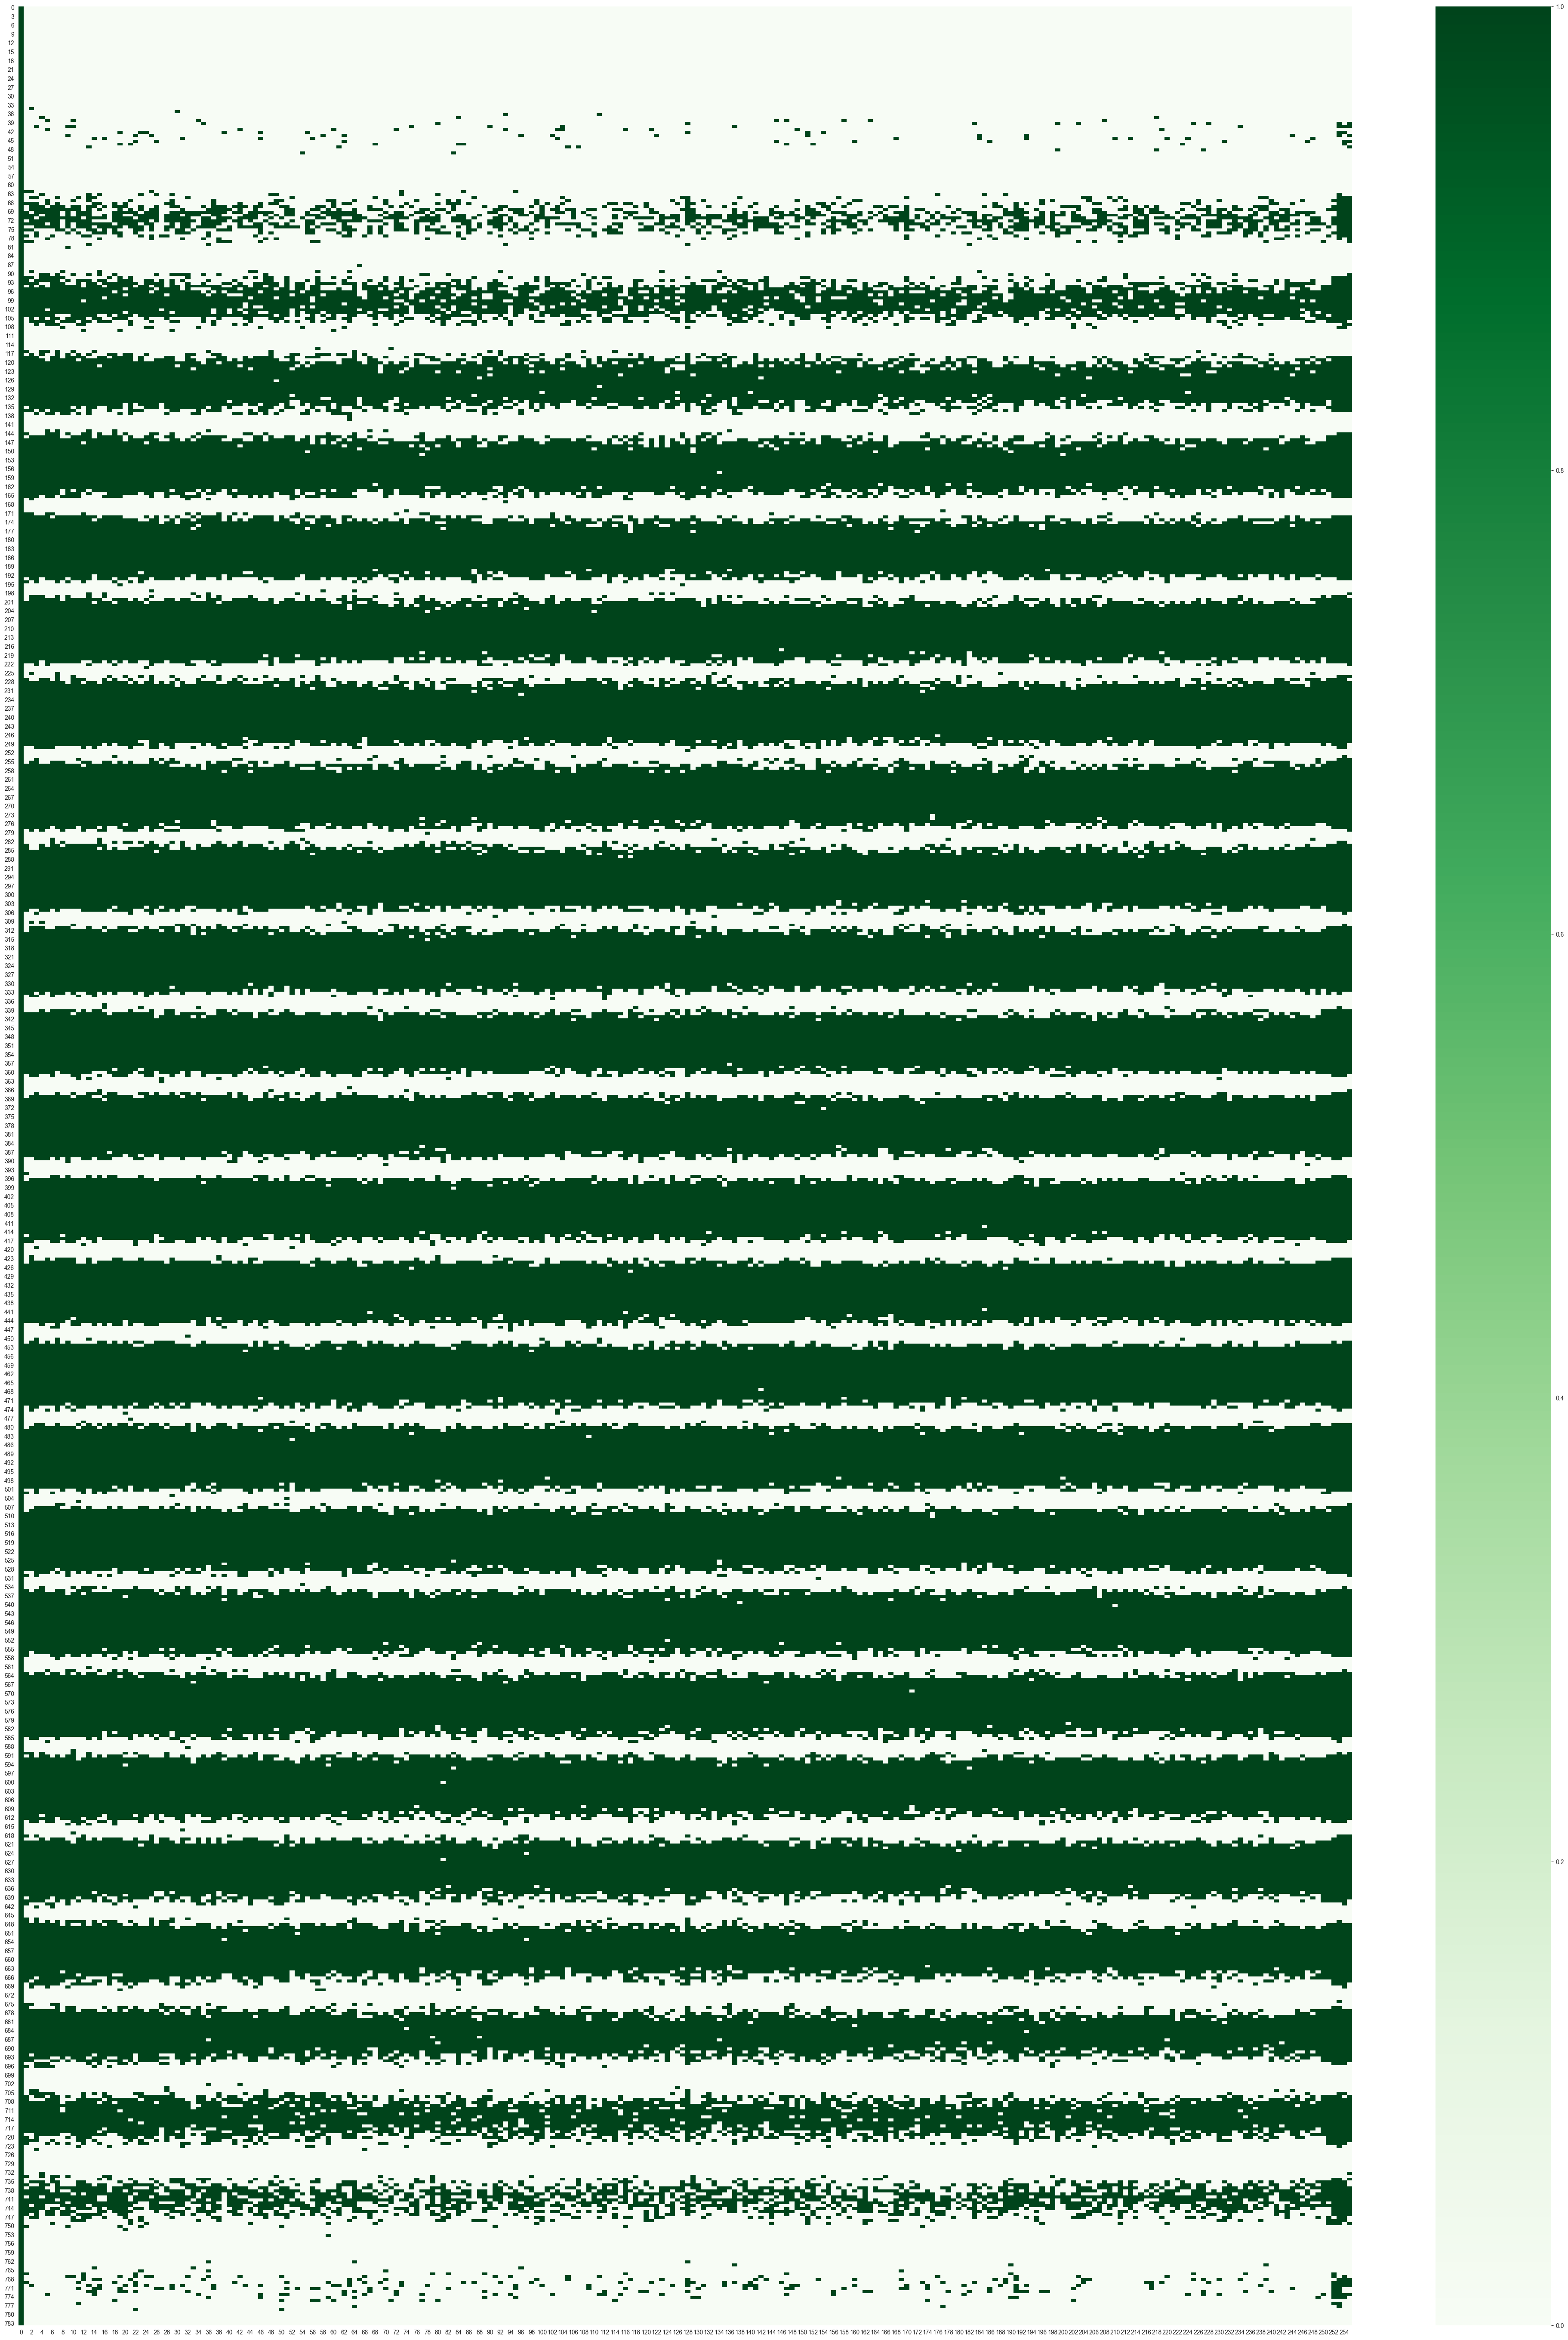

In [206]:
fig, ax = plt.subplots(figsize=(50,70))
sns.heatmap( data=x, vmin=0, vmax=1, cmap='Greens',ax=ax)

In [78]:
k = data[:,96] > 0

In [216]:
data_filtered = []
deleted = []
for i in range(data.shape[1]):
    k = data[:,i] > 0
    if sum(k) > 99:
        data_filtered.append(data[:,i] )
    else:
        print("deleted column:",i)
        deleted.append(i)

deleted column: 0
deleted column: 1
deleted column: 2
deleted column: 3
deleted column: 4
deleted column: 5
deleted column: 6
deleted column: 7
deleted column: 8
deleted column: 9
deleted column: 10
deleted column: 11
deleted column: 12
deleted column: 13
deleted column: 14
deleted column: 15
deleted column: 16
deleted column: 17
deleted column: 18
deleted column: 19
deleted column: 20
deleted column: 21
deleted column: 22
deleted column: 23
deleted column: 24
deleted column: 25
deleted column: 26
deleted column: 27
deleted column: 28
deleted column: 29
deleted column: 30
deleted column: 31
deleted column: 32
deleted column: 33
deleted column: 34
deleted column: 35
deleted column: 36
deleted column: 37
deleted column: 38
deleted column: 39
deleted column: 40
deleted column: 41
deleted column: 42
deleted column: 43
deleted column: 44
deleted column: 45
deleted column: 46
deleted column: 47
deleted column: 48
deleted column: 49
deleted column: 50
deleted column: 51
deleted column: 52
del

In [217]:
d = np.array(data_filtered)

In [218]:
# d.shape
d = d.transpose()

In [219]:
d.shape

(10740, 499)

In [225]:
c, cluster = runKmeanClustering(10,d,generateKCentroid(10,d.shape[1]))

============> 1
cluster does not have any data points:  1
============> 2
cluster does not have any data points:  9
============> 3
277
644
28
4
7
69
5309
48
3883
471
============> 4
1757
1152
286
47
332
610
2301
331
3120
804
============> 5
2048
872
428
212
487
929
1747
331
2766
920
============> 6
2078
692
553
366
565
971
1582
367
2570
996
============> 7
2105
583
645
489
604
1019
1499
408
2397
991
============> 8
2104
504
685
630
601
1078
1462
450
2246
980
============> 9
2030
509
689
796
567
1072
1444
498
2178
957
============> 10
1923
516
689
946
551
1053
1449
535
2131
947
============> 11
1846
535
713
1079
533
1032
1451
546
2061
944
============> 12
1801
548
728
1193
527
995
1457
561
1982
948
============> 13
1790
557
752
1270
515
967
1477
572
1881
959
============> 14
1790
547
782
1294
512
950
1508
574
1812
971
============> 15
1792
547
808
1293
509
949
1522
578
1762
980
============> 16
1799
551
844
1275
502
957
1522
580
1727
983
============> 17
1788
552
876
1285
501
958
1525


In [226]:
z = silhouette_score(data, cluster)

In [227]:
z

0.07154069039471486

In [228]:
cluster += 1

In [233]:
cluster

array([10,  8,  8, ...,  6,  6,  6])

In [234]:
import csv
outfile = open('./results.csv','w')
out = csv.writer(outfile)
out.writerows(map(lambda x: [x], cluster))
outfile.close()

In [ ]:
import  seaborn as sns
sns.pairplot(pd.DataFrame(data))

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x111b0c670> (for post_execute):



KeyboardInterrupt

